In [1]:
from scipy.signal import cheby2
from scipy.signal import sosfiltfilt
from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from scipy.signal import decimate
from scipy.signal.windows import blackman
import numpy as np
import matplotlib.pyplot as plt
import pprint

from libs import smooth

(array([ 445, 1223, 1971]),
 {'left_bases': array([ 266, 1033, 1805]),
  'prominences': array([154.20989077, 166.43104793,  67.1330777 ]),
  'right_bases': array([1033, 1805, 2099])})
(array([ 266, 1033, 1805]),
 {'left_bases': array([   0,  445, 1223]),
  'prominences': array([ 56.10895716, 156.44073574, 141.55556117]),
  'right_bases': array([ 445, 1223, 1971])})


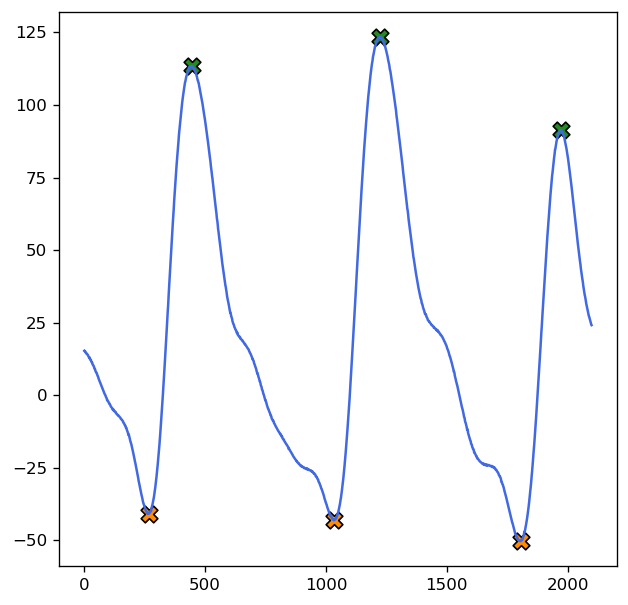

In [2]:
arr = np.loadtxt("ppg.csv", delimiter=",", dtype=float)

ppg_seg = arr[1, :]
fl = 0.4
fh = 8
fs = 1000

sos = cheby2(4, 20, [fl*2/fs, fh*2/fs], 'bandpass', output='sos')
filtered_ppg_seg = sosfiltfilt(sos, ppg_seg) 
ppg_seg_mean = np.mean(filtered_ppg_seg)
ppg_seg_std = np.std(filtered_ppg_seg)

ppg_maximas = find_peaks(filtered_ppg_seg, prominence=10)
ppg_minimas = find_peaks(-filtered_ppg_seg, prominence=10)

pprint.pprint(ppg_maximas)
pprint.pprint(ppg_minimas)

fig, axe = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
axe.plot(filtered_ppg_seg, c='royalblue')
axe.scatter(ppg_maximas[0], filtered_ppg_seg[ppg_maximas[0]], marker='X', s=100, linewidth=1, edgecolors='black', c='forestgreen')
axe.scatter(ppg_minimas[0], filtered_ppg_seg[ppg_minimas[0]], marker='X', s=100, linewidth=1, edgecolors='black', c='darkorange')


In [ ]:
#rrcycle = filtered_ppg_seg[ppg_minimas[0][0]: ppg_minimas[0][1]]
#rrcycle = rrcycle - np.min(rrcycle)
#out = gdecomp.GaussianDecomposition(rrcycle, 70)
#out = np.reshape(out, (-1, 3))
#print(out.shape)
#
#x=np.arange(rrcycle.size)
#fit = np.zeros(rrcycle.size)
#comps = list()
#for i in range(out.shape[0]):
#    comps.append(out[i,0] / (np.sqrt(2 * np.pi)*out[i,2]) * np.exp(-(x - out[i,1])**2 / (2 * out[i,2]**2)))
#    fit += comps[-1] 
#
#fig, axe = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
#axe.plot(rrcycle, c='royalblue')
#axe.plot(fit, c='brown')
#for comp in comps:
#    axe.plot(comp)

In [ ]:
from scipy.optimize import least_squares

rrcycle = filtered_ppg_seg[ppg_minimas[0][0]: ppg_minimas[0][1]]
rrcycle = rrcycle - np.min(rrcycle)

p = np.zeros((4, 3))
# 0 - a
# 1 - mean
# 2 - std

p[0, 0] = 1
p[1, 0] = 2
p[2, 0] = 3
p[3, 0] = 4

p[0, 1] = 10
p[1, 1] = 20
p[2, 1] = 30
p[3, 1] = 40

p[0, 2] = 4
p[1, 2] = 3
p[2, 2] = 2
p[3, 2] = 1

def gaussian_comps(p, y0, n=4):
    signal_length = len(y0)
    p = np.reshape(p, (-1, 3))
    fit = np.zeros((signal_length, ))
    x = np.arange(signal_length)
    for i in range(n):
        fit += p[i,0] / (np.sqrt(2 * np.pi)*p[i,2]) * np.exp(-(x - p[i,1])**2 / (2 * p[i,2]**2))
    
    return fit - y0

print(rrcycle.shape)
#f = gaussian_comps(p, 4, 100)
fit_result = least_squares(gaussian_comps, np.squeeze(np.reshape(p, (-1, 1))), args=(rrcycle, ))

comps = list()

p_hat = np.reshape(fit_result.x, (-1, 3))
x = np.arange(len(rrcycle))
rrcycle_fit = np.zeros((len(rrcycle), ))

for i in range(p_hat.shape[0]):
    comps.append(p_hat[i,0] / (np.sqrt(2 * np.pi) * p_hat[i,2]) * np.exp(-(x - p_hat[i,1])**2 / (2 * p_hat[i,2]**2)))
    rrcycle_fit += comps[-1] 

pprint.pprint(p_hat)
fig, axe = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
axe.plot(rrcycle)
axe.plot(rrcycle_fit)

for comp in comps:
    axe.plot(comp)





In [17]:
from scipy.optimize import least_squares

rrcycle = filtered_ppg_seg[ppg_minimas[0][0]: ppg_minimas[0][1]]
rrcycle = rrcycle - np.min(rrcycle)

def gaussian_comp_f(l: int, p: np.ndarray) -> np.ndarray:
    """generate a gaussian 1d array with length L and parameters p

    Args:
        l (int): _description_
        p (np.ndarray): _description_

    Returns:
        np.ndarray: _description_
    """
    x = np.arange(l)
    return p[0] * np.exp(-(x - p[1])**2 / (2 * p[2]**2))


def gaussian_comp_error(p, y0, n):
    signal_length = len(y0)
    p = np.reshape(p, (-1, 3))
    fit = np.zeros((signal_length, ))
    x = np.arange(signal_length)
    for i in range(n):
        fit += gaussian_comp_f(signal_length, p[i])

    return fit - y0

def rrcycle_gaussian_decomp(rrcycle: np.ndarray, p_init: np.ndarray, verbose=False)->dict:
    """Decomposite one PPG RR cycle into guassians 1d numpy arrays

    Args:
        rrcycle (np.ndarray): One segment of PPG signal which contains one RR cycle. Sized L x 1. L refers to the length of the PPG segment.
        p_init (np.ndarray): The initial parameters for least square optimization. Sized N x 3. N refers to the desired number of gaussian components, while every component has 3 initial parameters, i.e. the A, mean, and std.
        verbose (bool, optional): whether prints diagnostic info. Defaults to False.

    Returns:
        dict: decomposition results:
            'gaussian_comps': list of N gaussian components with length L
            'gaussian_parameters': np.ndarray of N x 3

    """
    comp_n = p_init.shape[0]
 
    # generate optimization boundary
    lb = list()
    ub = list()
    for i in range(comp_n):
        for j in range(3):
            if j == 0:
                # a >= 0
                lb.append(0)
                ub.append(np.inf)
            elif j == 1:
                # mean >= 0
                lb.append(0)
                ub.append(np.inf)
            elif j == 2:
                # std. >= 0
                lb.append(0)
                ub.append(np.inf)
     
    fit_result = least_squares(gaussian_comp_error, np.squeeze(np.reshape(p_init, (-1, 1))), args=(rrcycle, comp_n), bounds=(lb, ub))
    p_hat = np.reshape(fit_result.x, (-1, 3))

    comps = list()

    x = np.arange(len(rrcycle))
    rrcycle_fit = np.zeros((len(rrcycle), ))

    for i in range(p_hat.shape[0]):
        comps.append(gaussian_comp_f(len(rrcycle), p_hat[i]))
        rrcycle_fit += comps[-1] 
    
    # sort the component by gaussian mean
    sidx = np.argsort(p_hat[:, 1])
    p_hat = p_hat[sidx]
    
    if verbose:
        pprint.pprint(p_hat)
        fig, axe = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
        axe.plot(rrcycle)
        axe.plot(rrcycle_fit)

        for comp in comps:
            axe.plot(comp)
    
    return {
        'gaussian_comps': comps,
        'gaussian_parameters': p_hat
    }

array([[ 70.70156826, 121.49132741,  46.98203364],
       [117.29308144, 206.37499056,  67.90931861],
       [ 58.48631506, 384.55362105, 120.08816009],
       [ 13.66964251, 646.80827875,  67.73373327]])


{'gaussian_comps': [array([2.49677916e+00, 2.63745769e+00, 2.78480069e+00, 2.93904328e+00,
         3.10042403e+00, 3.26918466e+00, 3.44556985e+00, 3.62982688e+00,
         3.82220532e+00, 4.02295673e+00, 4.23233423e+00, 4.45059217e+00,
         4.67798569e+00, 4.91477032e+00, 5.16120146e+00, 5.41753397e+00,
         5.68402164e+00, 5.96091665e+00, 6.24846905e+00, 6.54692618e+00,
         6.85653208e+00, 7.17752689e+00, 7.51014620e+00, 7.85462041e+00,
         8.21117408e+00, 8.58002522e+00, 8.96138460e+00, 9.35545504e+00,
         9.76243068e+00, 1.01824962e+01, 1.06158262e+01, 1.10625842e+01,
         1.15229220e+01, 1.19969792e+01, 1.24848819e+01, 1.29867421e+01,
         1.35026572e+01, 1.40327088e+01, 1.45769624e+01, 1.51354662e+01,
         1.57082504e+01, 1.62953269e+01, 1.68966881e+01, 1.75123062e+01,
         1.81421330e+01, 1.87860986e+01, 1.94441112e+01, 2.01160563e+01,
         2.08017961e+01, 2.15011691e+01, 2.22139896e+01, 2.29400467e+01,
         2.36791049e+01, 2.443090

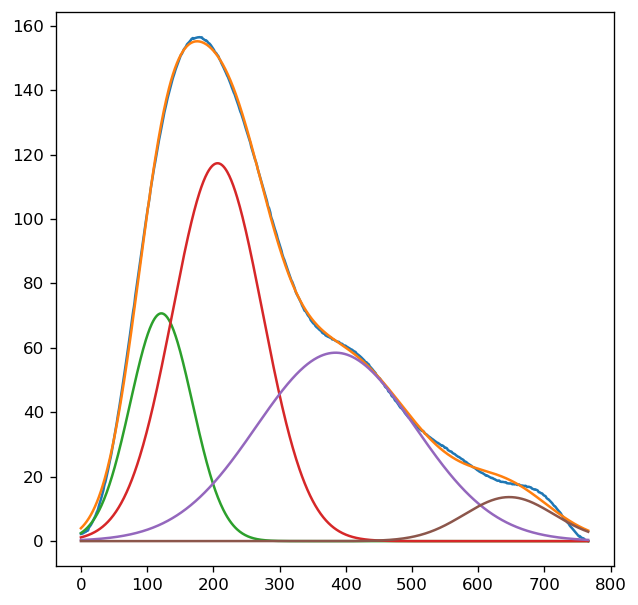

In [18]:
a = np.asarray([1, 100, 1])
b = np.asarray([1, 200, 1])
c = np.asarray([1, 300, 1])
d = np.asarray([1, 400, 1])

rrcycle_gaussian_decomp(rrcycle, np.stack((a, b, c, d)), True)






In [26]:

a = np.asarray([1, 100, 8])
b = np.asarray([2, 200, 7])
c = np.asarray([3, 300, 6])
d = np.asarray([4, 400, 5])

x = np.stack((b, d, c, a))

sidx = np.argsort(x[:, 1])
y = x[sidx]
print(y)


[[  1 100   8]
 [  2 200   7]
 [  3 300   6]
 [  4 400   5]]
